In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os
import six

sys.path.insert(0,"../")
import pyssht

from utils import brownian_motion, sph_utils, mesh_processing

In [25]:
N = 32
n = 400
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)
my_basis = sph_utils.SphHarmBasis(n_coeffs=n)

listpq = []

def sphere_function_x_start(theta, phi):
    return np.sin(theta)*np.cos(phi)

def sphere_function_y_start(theta, phi):
    return np.sin(theta)*np.sin(phi)

def sphere_function_z_start(theta, phi):
    return np.cos(theta)

def sphere_function_x_end(theta, phi):
    return 2*np.sin(theta)*np.cos(phi)

def sphere_function_y_end(theta, phi):
    return 2*np.sin(theta)*np.sin(phi)

def sphere_function_z_end(theta, phi):
    return 2*np.cos(theta)

In [8]:
coeffs_x_source = my_basis.sph_harm_transform(sphere_function_x_start)
coeffs_y_source = my_basis.sph_harm_transform(sphere_function_y_start)
coeffs_z_source = my_basis.sph_harm_transform(sphere_function_z_start)

coeffs_x_target = my_basis.sph_harm_transform(sphere_function_x_end)
coeffs_y_target = my_basis.sph_harm_transform(sphere_function_y_end)
coeffs_z_target = my_basis.sph_harm_transform(sphere_function_z_end)

In [9]:
reconstr_function_x_source = my_basis.sph_harm_reconstruct(coeffs_x_source)
reconstr_function_y_source = my_basis.sph_harm_reconstruct(coeffs_y_source)
reconstr_function_z_source = my_basis.sph_harm_reconstruct(coeffs_z_source)

f_recons_x_source = reconstr_function_x_source(theta,phi)
f_recons_y_source = reconstr_function_y_source(theta,phi)
f_recons_z_source = reconstr_function_z_source(theta,phi)

reconstr_function_x_target = my_basis.sph_harm_reconstruct(coeffs_x_target)
reconstr_function_y_target = my_basis.sph_harm_reconstruct(coeffs_y_target)
reconstr_function_z_target = my_basis.sph_harm_reconstruct(coeffs_z_target)

f_recons_x_target = reconstr_function_x_target(theta,phi)
f_recons_y_target = reconstr_function_y_target(theta,phi)
f_recons_z_target = reconstr_function_z_target(theta,phi)

(x_coord_source, y_coord_source, z_coord_source) = f_recons_x_source, f_recons_y_source, f_recons_z_source

(x_coord_target, y_coord_target, z_coord_target) = f_recons_x_target, f_recons_y_target, f_recons_z_target

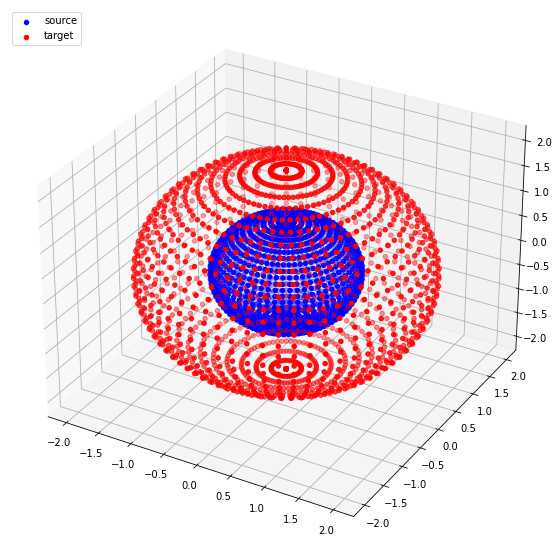

In [10]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord_source, y_coord_source, z_coord_source, c='b', label='source')
ax1.scatter(x_coord_target, y_coord_target, z_coord_target, c='r', label='target')

ax1.legend(loc = 'upper left')
plt.show()

## Bridge

In [16]:
t = 1

x = np.linspace(0, n, n)
lambdas = np.where(abs(x)<=25, 1, 0)
lambdas = np.array([1/(np.sqrt((k+2)*(k+1))) for k in range (0,n)])
Q = np.diag(lambdas)
#Q = np.eye(n)

reconstr_function_x = my_basis.sph_harm_reconstruct_bridge(coeffs_x_source, coeffs_x_target,
                                                           t = t, theta = theta, phi = phi, Q = Q, n_step = 50)[0]
reconstr_function_y = my_basis.sph_harm_reconstruct_bridge(coeffs_y_source, coeffs_y_target,
                                                           t = t, theta = theta, phi = phi, Q = Q, n_step = 50)[0]
reconstr_function_z = my_basis.sph_harm_reconstruct_bridge(coeffs_z_source, coeffs_z_target,
                                                           t = t, theta = theta, phi = phi, Q = Q, n_step = 50)[0]

### Remark !

In [17]:
#plt.figure(figsize=(12,4))
#plt.subplot(1,2,1)
#plt.plot(test[1][0])
#plt.title("Coeff")

#plt.subplot(1,2,2)
#plt.plot(reconstr_function_r[:,0])
#plt.title("Func")

The bridge on the coefficients does not descend as smoothly on the function: it depends on the basis !

### Visuals

In [18]:
listpq = []
for t in range(reconstr_function_x.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = reconstr_function_x[t], reconstr_function_y[t], reconstr_function_z[t]
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

#setting up the faces for the mesh
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

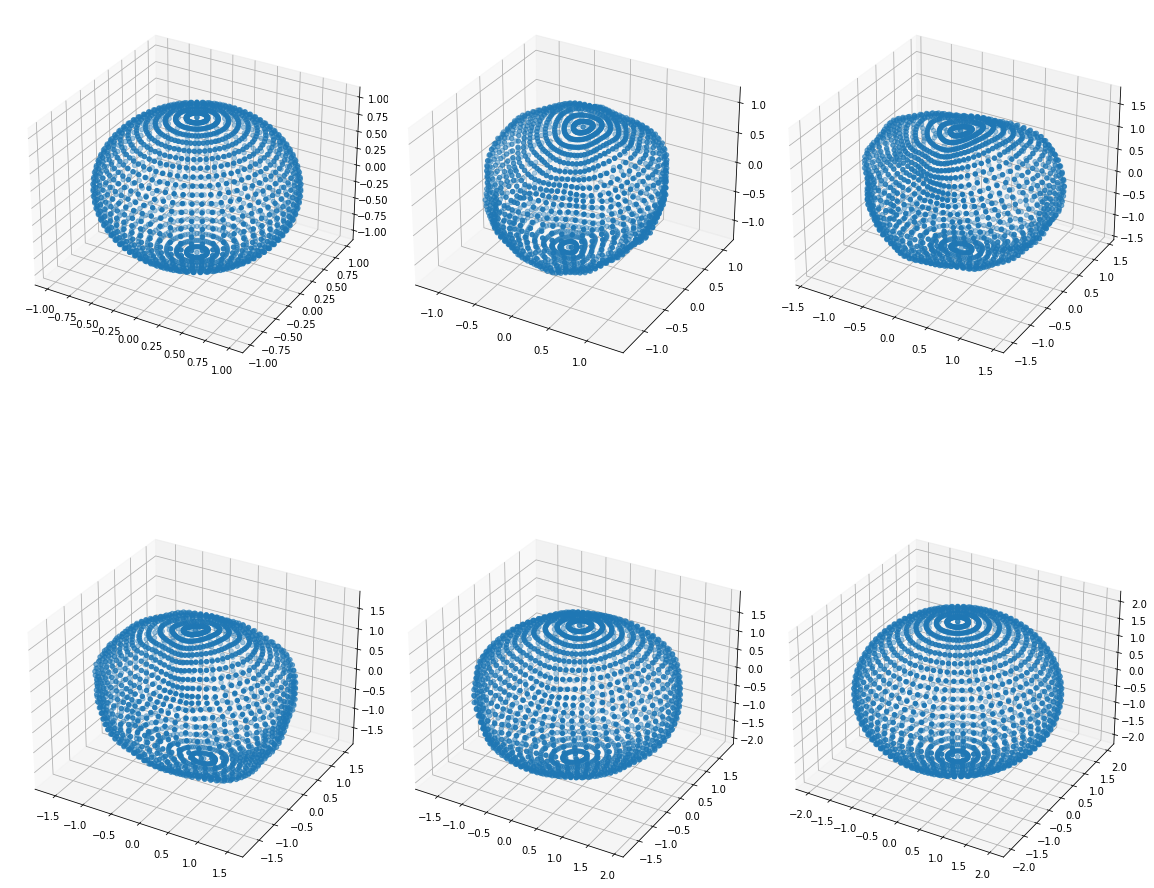

In [19]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[10,:,:].T[rows_unique[1]][:,0], listpq[10,:,:].T[rows_unique[1]][:,1], listpq[10,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[20,:,:].T[rows_unique[1]][:,0], listpq[20,:,:].T[rows_unique[1]][:,1], listpq[20,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[30,:,:].T[rows_unique[1]][:,0], listpq[30,:,:].T[rows_unique[1]][:,1], listpq[30,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[40,:,:].T[rows_unique[1]][:,0], listpq[40,:,:].T[rows_unique[1]][:,1], listpq[40,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[-1,:,:].T[rows_unique[1]][:,0], listpq[-1,:,:].T[rows_unique[1]][:,1], listpq[-1,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

### mesh .gif export

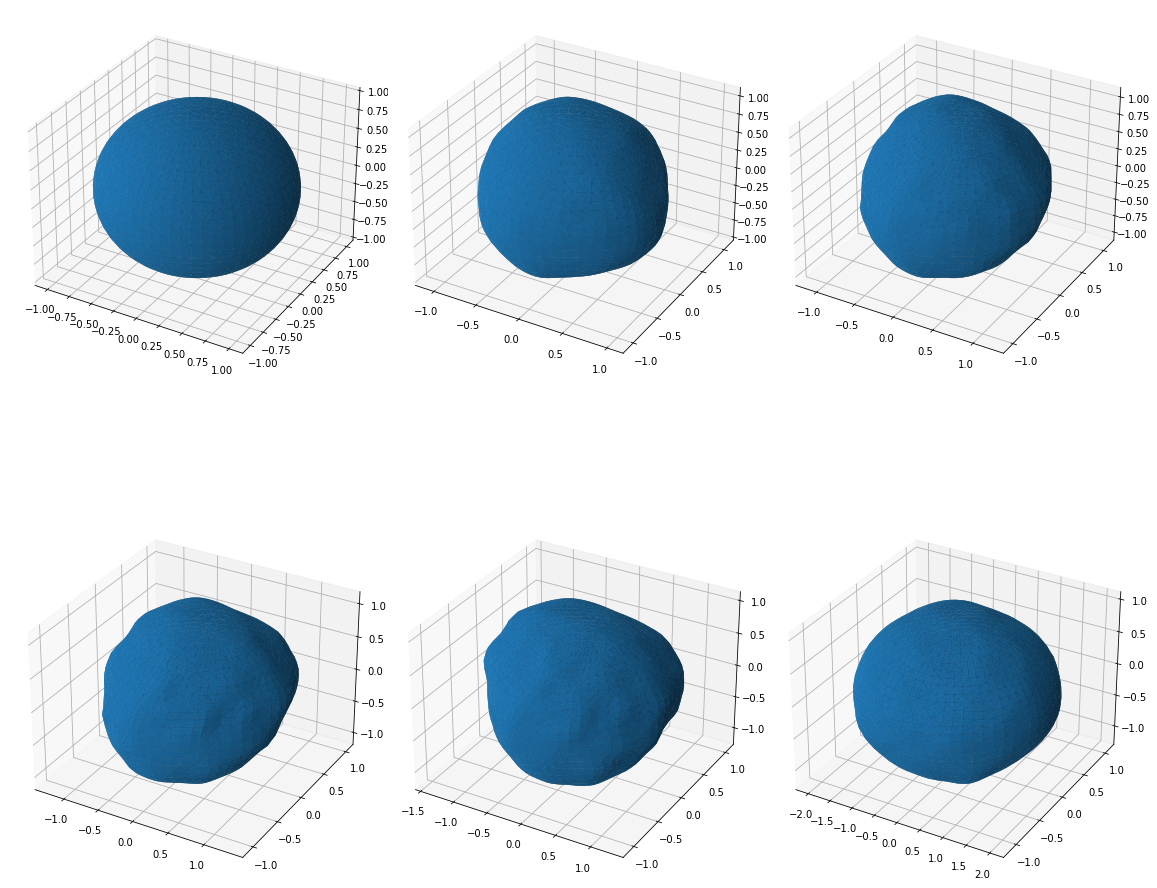

In [20]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[8,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[12,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[16,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[-1,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

In [21]:
mesh_processing.create_gif(listpq, "tests/bridge_new" ,"Q_squared_400coeffs.gif", auto_scale = False)

### SDE traj class

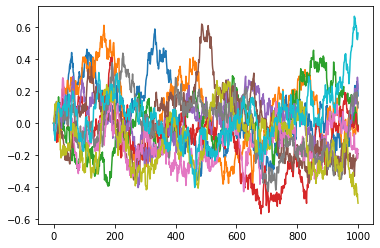

In [12]:
#b = lambda t, x: np.cos(x)*t
#sigma = lambda t,x: np.exp(-np.sqrt(np.abs(x))) + t
theta = 1
mu = 0
s = 0.3

b = lambda t, x: - theta*(x - mu)
sigma = lambda t,x: s

X = []
for i in range(10):
    X.append(brownian_motion.Diffusion_process(b = b, sigma = sigma).gen_traj(n_step = 1000, T=10))

plt.plot(np.array(X).T)
plt.show()

In [13]:
t = 1

x = np.linspace(0, n, n)
lambdas = np.where(abs(x)<=25, 1, 0)
Q = np.diag(lambdas)
#Q = np.eye(n)

test = my_basis.sph_harm_reconstruct_sde(coeffs_r_source, t = t, theta = theta, phi = phi, Q = Q, b = b, sigma = sigma, n_step = 50)
reconstr_function_r = test[0]
reconstr_function_theta = my_basis.sph_harm_reconstruct_sde(coeffs_theta_source, t = t, theta = theta, phi = phi, Q = Q,
                                                            b = b, sigma = sigma, n_step = 50)[0]
reconstr_function_phi = my_basis.sph_harm_reconstruct_sde(coeffs_phi_source, t = t, theta = theta, phi = phi, Q = Q,
                                                          b = b, sigma = sigma, n_step=50)[0]

In [14]:
listpq = []
for t in range(reconstr_function_r.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = pyssht.spherical_to_cart(reconstr_function_r[t], 
                                                                             reconstr_function_theta[t], 
                                                                             reconstr_function_phi[t])
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

#setting up the faces for the mesh
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

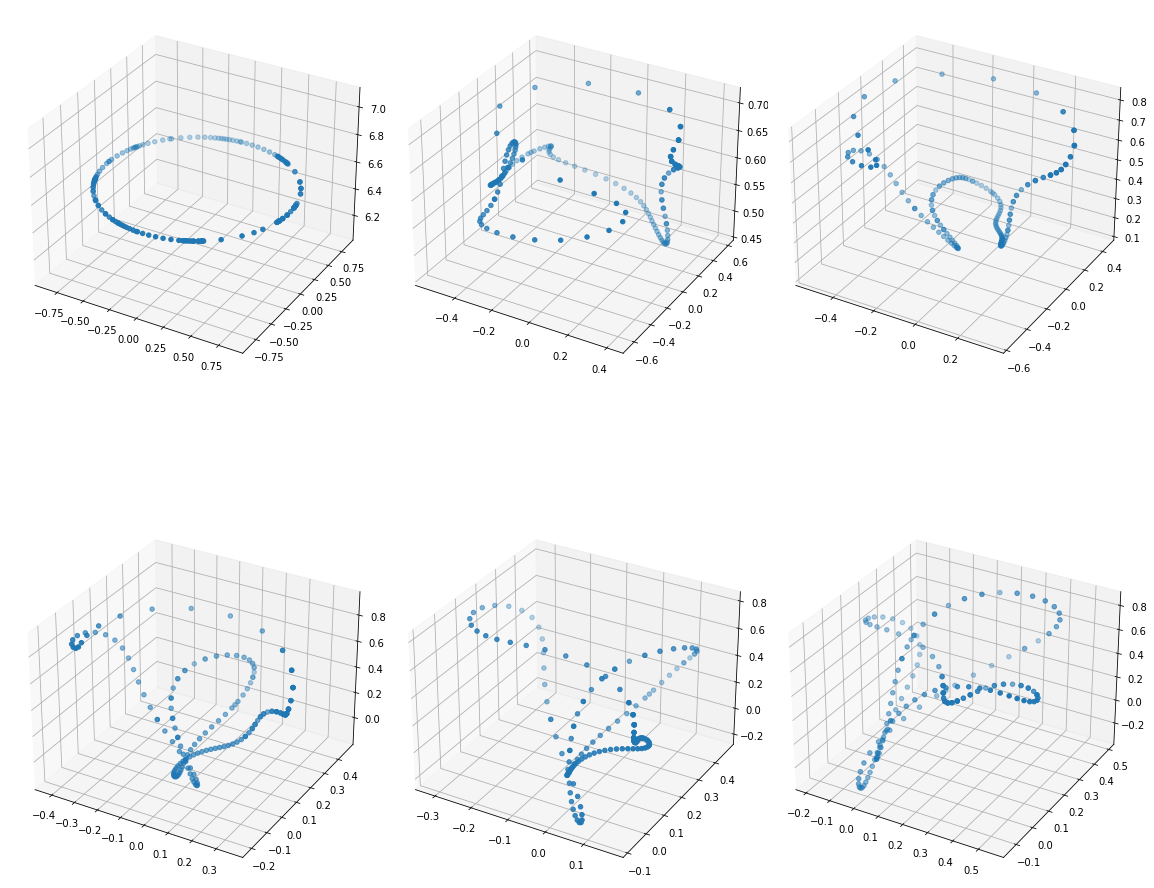

In [15]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[10,:,:].T[rows_unique[1]][:,0], listpq[10,:,:].T[rows_unique[1]][:,1], listpq[10,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[20,:,:].T[rows_unique[1]][:,0], listpq[20,:,:].T[rows_unique[1]][:,1], listpq[20,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[30,:,:].T[rows_unique[1]][:,0], listpq[30,:,:].T[rows_unique[1]][:,1], listpq[30,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[40,:,:].T[rows_unique[1]][:,0], listpq[40,:,:].T[rows_unique[1]][:,1], listpq[40,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[-1,:,:].T[rows_unique[1]][:,0], listpq[-1,:,:].T[rows_unique[1]][:,1], listpq[-1,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

In [ ]:
mesh_processing.create_gif(listpq, "tests/sde" ,"test_OU.gif", auto_scale = False)